In [302]:
# See utils.py for the imports

from utils import *
import os
import warnings
warnings.filterwarnings('ignore')

import timeit
import nest_asyncio
nest_asyncio.apply()
#%load_ext line_profiler

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Where to save the figures (adapted this from https://github.com/ageron/handson-ml2)
PROJECT_ROOT_DIR = "."
PROJECT_ID = "stock_movement_tweet_data_wrangling"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=72):
    """ 
    resolution quality
    300 high 
    150 medium
    72 low
    """
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
plt.style.use('fivethirtyeight')

In [312]:
def combine_tweets_user(df):
    # convert dates to datetime and split
    datetimes = pd.to_datetime(df['created_at'])
    df['time'], df['date'] = datetimes.dt.time, datetimes.dt.date
    
    # get open and closing times
    open_t = dt.strptime('09:30:00', '%H:%M:%S').time()
    close_t = dt.strptime('16:00:00', '%H:%M:%S').time()
    
    # filter dataframes based off when tweet occurs
    before_df = df[df['time'] < open_t]
    during_df = df[((df['time'] >= open_t) & (df['time'] < close_t))]
    after_df = df[df['time'] >= close_t]
    
    # reset tweet times to next open or close time
    before_df['time'] = open_t
    during_df['time'] = close_t
    
    # if tweet occurs after close, set it to next day and set time to open
    after_df['date'] += timedelta(days=1)
    after_df['time'] = open_t

    # reassemble dataframes with updated dates/times
    df = before_df.append(during_df).append(after_df)
    
    # sort by date and time
    df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))
    df = df.sort_values(by='date', ascending=True)
    
    # collect tweets in a dictionary (key:value ->  Date : [tweets])
    collected_tweets = {}
    tweet = []
    combined_df = pd.DataFrame(index=sorted(list(set(df['date']))))
    combined_df['tweet'] = [[] for _ in range(len(combined_df))]
    
    # iterate over dataframe and add tweets to matching dates
    for i in range(len(combined_df)):
        time = combined_df.index[i]
        matching_dates = df[df['date'] == time]
        for tweet in matching_dates['tweet']:
            combined_df['tweet'].iloc[i].append(tweet)
     
    # add number of tweets and username and return
    combined_df['num_tweets'] = combined_df['tweet'].apply(lambda x: len(x))
    combined_df['username'] = df['username'].unique()[0]
    return combined_df

def combine_tweets(full_df, verbose=False):
    """
    group tweets together by next open/close date
    
    Arguments:
    full_df -- A dataframe of users tweets and created_at dates. 
    
    Returns:
    merged_df -- A dataframe of grouped user tweets as lists before the next open/close datetime
  
    A tweet is grouped via the following criteria:
    market_open = 09:30:00 EST
    market_close = 16:00:00 EST
    
    - If tweet created_at occurs before market_open on same date, it is grouped as before_market_tweets. 
    - It tweet is on or after market_open but before market_close, (i.e. during market hours) it is grouped as during_market_tweets. 
    - If tweet is on or after market_close, it is grouped as after_market_tweets.
    """
    
    users = full_df.username.unique()
    merged_df = pd.DataFrame()
    if verbose:
        max_length = 11963
        start = timeit.default_timer()
        print('')
        print('digesting dataframes....')
        print('---{:.2f} % complete -------'.format(0.0))
    for user in users:
        merged_df = merged_df.append(combine_tweets_user(full_df[full_df['username'] == user]))
        if verbose:
            print('')
            print('--{:.2f} % complete -------'.format(100*len(merged_df) / max_length))
    if verbose:
        stop = timeit.default_timer()
        print('digestion completed ---- runtime {:.2f} seconds'.format(stop - start))
    return merged_df.reset_index(drop=False).rename(columns={'index':'date'})
    
def combine_tweets_stocks(ceos_merged, stocks_full):
    new_df = pd.DataFrame()
    for user in ceos_merged['username'].unique():
        ticker = handles_tickers[user]
        tweet_df = ceos_merged[ceos_merged['username'] == user]
        stock_df = stocks_full[stocks_full['ticker'] == ticker]
        new_df = new_df.append(tweet_df.merge(stock_df, how='left', on='date')).dropna(subset=['ticker'])  
    return new_df

def fix_closed_market_tweets(test):
    test = test.dropna()
    test.reset_index(inplace=True, drop=True)
    test = test.set_index('date')
    for i in range(len(test)):
        test['tweet'].iloc[i] += " "

    i = 0
    combined=pd.DataFrame()

    while i < len(test):
        if test['price'].iloc[i] == 0:
            combined = test.iloc[i]
            j = i + 1
            while test['price'].iloc[j] == 0:
                combined += test.iloc[j]
                j += 1
            username = test.iloc[j]['username']
            price = test.iloc[j]['price']
            percent_change = test.iloc[j]['percent change']
            test.iloc[j] += combined
            test['username'].iloc[j] = username
            test['price'].iloc[j] = price
            test['percent change'].iloc[j] = percent_change
            i = j
        i += 1
    test = test[test['price'] !=0]
    return test

def organize_stocks(df): 
    """
    Combines the open/close dates and prices into a single dataframe
    """
    stock_open = pd.DataFrame()
    stock_close = pd.DataFrame()

    stock_open['date'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d 09:30:00'))
    stock_close['date'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d 16:00:00'))

    stock_open['price'] = df['open']
    stock_close['price'] = df['close']
    
    start_date_open = dt.strftime(stock_open.date.min(), '%Y-%m-%d %H:%M:%S')
    start_date_close = dt.strftime(stock_close.date.min(), '%Y-%m-%d %H:%M:%S')

    end_date_open = dt.strftime(stock_open.date.max(), '%Y-%m-%d %H:%M:%S')
    end_date_close = dt.strftime(stock_close.date.max(), '%Y-%m-%d %H:%M:%S')
    
    date_indx_open = pd.Series(pd.date_range(start_date_open, end_date_open), name='date')
    date_indx_close = pd.Series(pd.date_range(start_date_close, end_date_close), name='date')
    
    stock_open = pd.merge(date_indx_open, stock_open, how='left')
    stock_close = pd.merge(date_indx_close, stock_close, how='left')
    
    stock = pd.concat([stock_open, stock_close])
    return stock.sort_values(by='date', ascending=True)

# Collecting Data

In [313]:
# Collect the stock data from yahoo Finance and organize a dictionary of dataframes with the open/close prices combined. 
usernames = ['elonmusk', 'levie', 'jack', 'Benioff','richardbranson', 'JohnLegere']
stock_names = ['TSLA','BOX', 'TWTR','CRM','SPCE', 'TMUS']
user_stock_mapping = dict(zip(usernames, stock_names))
stocks = {stock:pd.read_pickle(f'data/{stock}.pkl') for stock in stock_names}

In [314]:
# Get needed columns and change the date to lowercase
for stock in stocks:
    stocks[stock].reset_index(inplace=True)
    stocks[stock] =  stocks[stock][['Date','Open', 'Close']]
    stocks[stock].columns = stocks[stock].columns.str.lower()

In [315]:
for stock in stocks:
    stocks[stock] = organize_stocks(stocks[stock])

### De-trending the time series stock data 

We will use the percent change in the stock prices as a target that we will later bin into categories.  

In [316]:
# create a percent change column from the price feature
for stock in stocks:
    stocks[stock]['percent change'] = stocks[stock]['price'].pct_change()
    stocks[stock].fillna(0, inplace=True)
    
# convert to dataframe
stocks_full = pd.DataFrame()
for stock in stocks:
    # get stock ticker for grouping
    stocks[stock]['ticker'] = stock
    stocks_full = stocks_full.append(stocks[stock])

# pickle and save
#pd.to_pickle(stocks_full, './data/stocks_full_df.pkl')

## 1.2.5 Collecting the tweets <a id='1.2.5_Collecting_Tweet'></a>
We will collect the CEOs tweets over the same time-span as the collected stocks

In [317]:
# Get the tweets from the CEOs of the companies
        
handles_tickers = {'elonmusk':'TSLA', 'levie':'BOX','jack':'TWTR', 'Benioff':'CRM', 
            'richardbranson':'SPCE', 'JohnLegere':'TMUS'}

start_date = {}
for user in handles_tickers:
    start_date[user] = dt.strftime(stocks[handles_tickers[user]].reset_index().date.min(), '%Y-%m-%d %H:%M:%S')
    
ceos = pd.read_pickle('./data/ceos.pkl')

In [318]:
ceos_merged = combine_tweets(ceos, verbose=True)
wrangled_df = combine_tweets_stocks(ceos_merged, stocks_full)


digesting dataframes....
---0.00 % complete -------

--18.38 % complete -------

--26.44 % complete -------

--38.93 % complete -------

--54.63 % complete -------

--71.44 % complete -------

--100.00 % complete -------
digestion completed ---- runtime 66.36 seconds


In [378]:
wrangled_df.loc[22]['tweet']

22    [Journalist Q&amp;A for 30 mins and embargo en...
22    [7,000 people registered for BoxWorks this wee...
22    [When was the last time you tried something fo...
Name: tweet, dtype: object

In [319]:
def combine_tweets_stocks(ceos_merged, stocks_full):
    new_df = pd.DataFrame()
    for user in ceos_merged['username'].unique():
        ticker = handles_tickers[user]
        tweet_df = ceos_merged[ceos_merged['username'] == user]
        stock_df = stocks_full[stocks_full['ticker'] == ticker]
        
        # drop na values where 
        new_df = new_df.append(tweet_df.merge(stock_df, how='left', on='date')).dropna(subset=['ticker'])  
    return new_df

In [ ]:
####################
######!!WORK!!######
####################

In [ ]:
####################
######!!WORK!!######
####################

In [ ]:
####################
######!!WORK!!######
####################

In [ ]:
####################
######!!WORK!!######
####################

In [ ]:
####################
######!!WORK!!######
####################

In [375]:
####################
######!!WORK!!######
####################

In [376]:
df = wrangled_df[wrangled_df['username'] == 'elonmusk'].copy(deep=True)

In [377]:
df.set_index('date')['2021-07-16 16:00:00': '2021-07-19 09:30:00']

,tweet,num_tweets,username,price,percent change,ticker
date,,,,,,
2021-07-16 16:00:00,"[@TeslaNY Do you even press?, @Teslarati Impro...",4,elonmusk,644.219971,-0.015977,TSLA
2021-07-17 09:30:00,"[@fael097 Pure coincidence!, @ValaAfshar Even ...",9,elonmusk,0.000000,0.000000,TSLA
2021-07-17 16:00:00,"[@SamTwits Nice, https://t.co/d4ZOSKZESP, Tap...",12,elonmusk,0.000000,0.000000,TSLA
2021-07-18 09:30:00,"[@ArtifactsHub And all-time hodl champion, @Ar...",6,elonmusk,0.000000,0.000000,TSLA
2021-07-18 16:00:00,"[@thePiggsBoson Problem 1st, theory 2nd is for...",1,elonmusk,0.000000,0.000000,TSLA
2021-07-19 09:30:00,"[@DragTimes @Tesla Nice, @grimnut @Tesla @Whol...",3,elonmusk,629.890015,-0.022244,TSLA


In [368]:
df = df.set_index('date')
combined = pd.DataFrame()
i = 0
while i < len(df):
    
    # find where price is zero (saturday, sunday, or holiday)
    if df['price'].iloc[i] == 0:
        combined = df[['tweet', 'num_tweets']].iloc[i]
        
        # iterate through dataframe until next non-zero price entry
        j = i + 1
        while df['price'].iloc[j] == 0:
            combined += df[['tweet', 'num_tweets']].iloc[j]
            j += 1
        username = df.iloc[j]['username']
        price = df.iloc[j]['price']
        percent_change = df.iloc[j]['percent change']
        df.iloc[j] += combined
        df['username'].iloc[j] = username
        df['price'].iloc[j] = price
        df['percent change'].iloc[j] = percent_change
        i = j
    i += 1
df = df[df['price'] !=0]

In [369]:
df

,tweet,num_tweets,username,price,percent change,ticker
date,,,,,,
2016-08-23 16:00:00,[Journalist Q&amp;A for 30 mins and embargo en...,2,elonmusk,44.967999,0.002318,TSLA
2016-08-30 16:00:00,[Thanks for the longstanding faith in SpaceX. ...,3,elonmusk,42.268002,-0.022072,NaN
2016-08-31 16:00:00,"[@Lockyep Not allowed, according to HK regulat...",5,elonmusk,42.402000,0.007508,TSLA
2016-09-01 16:00:00,[Loss of Falcon vehicle today during propellan...,1,elonmusk,40.153999,-0.039424,TSLA
2016-09-02 09:30:00,[Finishing Autopilot blog postponed to end of...,2,elonmusk,40.466000,0.007770,TSLA
...,...,...,...,...,...,...
2021-07-16 09:30:00,"[@AaronS5_ @FrenchieEAP @karpathy Yes, @Austin...",4,elonmusk,654.679993,0.006271,TSLA
2021-07-16 16:00:00,"[@TeslaNY Do you even press?, @Teslarati Impro...",4,elonmusk,644.219971,-0.015977,TSLA
2021-07-19 09:30:00,"[@DragTimes @Tesla Nice, @grimnut @Tesla @Whol...",31,elonmusk,629.890015,-0.022244,NaN


In [374]:
df['2021-07-16 16:00:00': '2021-07-19 09:30:00']

,tweet,num_tweets,username,price,percent change,ticker
date,,,,,,
2021-07-16 16:00:00,"[@TeslaNY Do you even press?, @Teslarati Impro...",4,elonmusk,644.219971,-0.015977,TSLA
2021-07-19 09:30:00,"[@DragTimes @Tesla Nice, @grimnut @Tesla @Whol...",31,elonmusk,629.890015,-0.022244,NaN


In [14]:
####################
######!!SNIP!!######
####################
def snip1(df):
    df = df.set_index('date')
    combined = pd.DataFrame()
    i = 0
    while i < len(df):
        if df['price'].iloc[i] == 0:
            combined = df.iloc[i]
            j = i + 1
            while df['price'].iloc[j] == 0:
                combined += df.iloc[j]
                j += 1
            username = df.iloc[j]['username']
            price = df.iloc[j]['price']
            percent_change = df.iloc[j]['percent change']
            df.iloc[j] += combined
            df['username'].iloc[j] = username
            df['price'].iloc[j] = price
            df['percent change'].iloc[j] = percent_change
            i = j
        i += 1
    df = df[df['price'] !=0]
    return df

In [18]:
df = wrangled_df[wrangled_df['username'] == 'elonmusk']
df

,date,tweet,num_tweets,username,price,percent change,ticker
22,2016-08-23 16:00:00,[Journalist Q&amp;A for 30 mins and embargo en...,2,elonmusk,44.967999,0.002318,TSLA
23,2016-08-28 09:30:00,"[@Kotaku one of my favorite games as a kid, @B...",2,elonmusk,44.162666,0.011081,TSLA
24,2016-08-30 16:00:00,[Thanks for the longstanding faith in SpaceX. ...,1,elonmusk,42.268002,-0.022072,TSLA
25,2016-08-31 16:00:00,"[@Lockyep Not allowed, according to HK regulat...",5,elonmusk,42.402000,0.007508,TSLA
26,2016-09-01 16:00:00,[Loss of Falcon vehicle today during propellan...,1,elonmusk,40.153999,-0.039424,TSLA
...,...,...,...,...,...,...,...
2194,2021-07-18 09:30:00,"[@ArtifactsHub And all-time hodl champion, @Ar...",6,elonmusk,638.153341,-0.010441,TSLA
2195,2021-07-18 16:00:00,"[@thePiggsBoson Problem 1st, theory 2nd is for...",1,elonmusk,645.553304,0.011596,TSLA
2196,2021-07-19 09:30:00,"[@DragTimes @Tesla Nice, @grimnut @Tesla @Whol...",3,elonmusk,629.890015,-0.024263,TSLA
2197,2021-07-19 16:00:00,"[@jack @BitcoinMagazine @CathieDWood Sure, I h...",2,elonmusk,646.219971,0.025925,TSLA


In [19]:
test = snip1(df)

In [25]:
test['num_tweets'] 

date
2016-08-23 16:00:00    2
2016-08-28 09:30:00    2
2016-08-30 16:00:00    1
2016-08-31 16:00:00    5
2016-09-01 16:00:00    1
                      ..
2021-07-18 09:30:00    6
2021-07-18 16:00:00    1
2021-07-19 09:30:00    3
2021-07-19 16:00:00    2
2021-07-20 09:30:00    5
Name: num_tweets, Length: 2177, dtype: int64

In [ ]:
####################
######!!REST!!######
####################

In [ ]:
####################
######!!FULL!!######
####################

def fix_closed_market_tweets(test):
    test = test.dropna()
    test.reset_index(inplace=True, drop=True)
    test = test.set_index('date')
    for i in range(len(test)):
        test['tweet'].iloc[i] += " "

    i = 0
    combined=pd.DataFrame()

    while i < len(test):
        if test['price'].iloc[i] == 0:
            combined = test.iloc[i]
            j = i + 1
            while test['price'].iloc[j] == 0:
                combined += test.iloc[j]
                j += 1
            username = test.iloc[j]['username']
            price = test.iloc[j]['price']
            percent_change = test.iloc[j]['percent change']
            test.iloc[j] += combined
            test['username'].iloc[j] = username
            test['price'].iloc[j] = price
            test['percent change'].iloc[j] = percent_change
            i = j
        i += 1
    test = test[test['price'] !=0]
    return test

In [ ]:
####################
######!!WORK!!######
####################

In [ ]:
####################
######!!WORK!!######
####################

In [ ]:
####################
######!!WORK!!######
####################

In [ ]:
####################
######!!WORK!!######
####################

In [ ]:
####################
######!!WORK!!######
####################

In [ ]:
####################
######!!WORK!!######
####################

In [166]:
wrangled_df = wrangled_df.set_index('date')

In [167]:
wrangled_df.columns

Index(['tweet', 'num_tweets', 'username', 'price', 'percent change', 'ticker'], dtype='object')

<AxesSubplot:xlabel='date'>

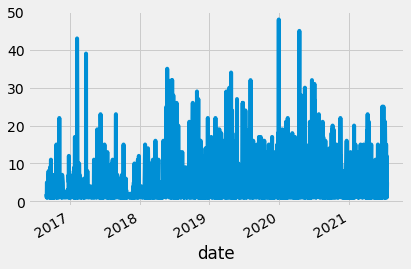

In [168]:
wrangled_df[wrangled_df['username'] == 'elonmusk']['num_tweets'].plot()

# Text Analysis/Cleaning/and Preprocessing

In [25]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.corpora import Dictionary

# Corpus
tweet_corpus = list(ceos['tweet'].values)

# tokenize
texts = [[text for text in doc.split()] for doc in tweet_corpus]

# Dictionary
dictionary = Dictionary(texts)

In [85]:
# regex patterns
import re
import html 
import demoji
from collections import Counter
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import contractions

demoji.download_codes()
EMAIL_PATTERN = r'[A-Za-z0-9]+[@]+[^\s]+'
MENTION_PATTERN = r'[@]+[^\s]+'
HASHTAG_PATTERN = r'[#]\S+'
LINK_PATTERN = r'https?:\S+'
CASHTAG_PATTERN = r'[$][A-Z]+'
EMOJIS_PATTERN = r'((:\))|(;\)))'

stop_words = []

STOP_WORDS = STOP_WORDS.union(set(['s', 'it', 'm', 'you', 're', 'it ', ' s', 's ', 'i', 't', 'week', 'month', 'year', 'day']))

def engineer_tweet_features(wrangled_df, method='count'):
    """
    Takes in raw tweet and extracts mentions, hashtags, links,
    (currently only counts, will look into scikit learn before implementing my own code for future transformations)
    """
    
    
    wrangled_df[['emails', 'links', 'mentions', 'hashtags', 'emojis']] = 0
    features_df = wrangled_df[['emails', 'links', 'mentions', 'hashtags', 'emojis']] 
    features_df['emails'] = wrangled_df['tweet'].apply(lambda x: re.findall(EMAIL_PATTERN, x)).apply(lambda x: len(x))
    features_df['links'] = wrangled_df['tweet'].apply(lambda x: re.findall(LINK_PATTERN, x)).apply(lambda x: len(x))
    features_df['mentions'] = wrangled_df['tweet'].apply(lambda x: re.findall(MENTION_PATTERN, x)).apply(lambda x: len(x))
    features_df['hashtags'] = wrangled_df['tweet'].apply(lambda x: re.findall(HASHTAG_PATTERN, x)).apply(lambda x: len(x))
    features_df['emojis'] = wrangled_df['tweet'].apply(lambda x: demoji.findall_list(x)).apply(lambda x: len(x))
    return features_df

import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
import normalize


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.username = userna,e
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])

def clean_text(sample_tweets, stop_words=None):
    """
    add normalize, do some exploring to see if any abbreviations need to be used
    https://towardsdatascience.com/text-preprocessing-steps-and-universal-pipeline-94233cb6725a
    """
    new_sample_tweets = html.unescape(sample_tweets)
    new_sample_tweets = ' '.join(re.sub(EMAIL_PATTERN, ' ', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(MENTION_PATTERN, ' ', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(HASHTAG_PATTERN, ' ', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(CASHTAG_PATTERN, ' ', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(LINK_PATTERN, ' ', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(r'(w/)', 'with ', new_sample_tweets).split())
    new_sample_tweets = demoji.replace(new_sample_tweets, repl=' ')
    new_sample_tweets = ' '.join(re.sub(r'((:\)))', 'smiling face', new_sample_tweets).split())
    new_sample_tweets = ' '.join(re.sub(r'((;\)))', 'winking face', new_sample_tweets).split())
    new_sample_tweets = new_sample_tweets.lower()
    new_sample_tweets = new_sample_tweets.replace('/', '')
    new_sample_tweets = new_sample_tweets.replace('\\', '')
    new_sample_tweets = ' '.join([contractions.fix(word) for word in new_sample_tweets.split()])
    new_sample_tweets = ' '.join(re.sub(r'[^a-z]', ' ', new_sample_tweets).split())
    new_sample_tweets = PorterStemmer().stem(new_sample_tweets) #
    new_sample_tweets = ' '.join([word for word in new_sample_tweets.split() if len(word) >2 ])
    if stop_words !=None:
        new_sample_tweets = ' '.join([word for word in new_sample_tweets.split() if word not in stop_words]) # Go through this
    return new_sample_tweets



In [86]:
%%time

# clean up and add counts of twitter tags
wrangled_df['cleaned'] = wrangled_df['tweet']
wrangled_df['cleaned'] = wrangled_df['tweet'].apply(lambda x: clean_text(x))
wrangled_df[['emails', 'links', 'mentions', 'hashtags', 'emojis']] = engineer_tweet_features(wrangled_df)

CPU times: user 1min 12s, sys: 1.68 s, total: 1min 14s
Wall time: 1min 40s


In [29]:
# make some data to play with
X, y = wrangled_df[['emails', 'links', 'mentions', 'hashtags', 'emojis']], wrangled_df['percent change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Word2Vec

In this exercise you will create a Word2Vec model using Keras.

The corpus used to pre-train the model is the script of all episodes of the The Big Bang Theory TV show, divided sentence by sentence. It is available in the variable bigbang.

The text on the corpus was transformed to lower case and all words were tokenized. The result is stored in the tokenized_corpus variable.

A Word2Vec model was pre-trained using a window size of 10 words for context (5 before and 5 after the center word), words with less than 3 occurrences were removed and the skip gram model method was used with 50 dimension. The model is saved on the file bigbang_word2vec.model.

The class Word2Vec is already loaded in the environment from gensim.models.word2vec.

In [ ]:
from gensim.models import word2vec

# Train the model
w2v_model = word2vec.Word2Vec(tokenized_corpus, size=embedding_dim, window=neighbor_words_num, iter=100)

# Get top 3 similar words to 'captain'
w2v_model.wv.most_similar(['captain'], topn=3)

## FastText

In [ ]:
from gensim.models import fasttext

# instatiate the model
ft_model = fasttext.FastText(size=embedding_dim, window=neighbor_words_num)

# Build vocabulary
ft_model.build_vocab(sentences=tokenized_corpus)

# train the model
ft_model.train(sentences=tokenized_corpus, total_examples=len(tokenized_corpus), epochs=100)

In [45]:
wrangled_df['target'] = wrangled_df['percent change'].apply(lambda x: 1 if x >= 0.005 else 0)

In [46]:
wrangled_df['target'].value_counts()

0    9238
1    2559
Name: target, dtype: int64

# XGBoost

In [48]:
import xgboost as xgb
X, y = X, y = wrangled_df[['emails', 'links', 'mentions', 'hashtags', 'emojis']], wrangled_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [61]:
%%time

train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params = {'objective':'reg:logistic', 'max_depth':3}

# num_boost_round = number of trees to build
cv_results = xgb.cv(dtrain=train_dmatrix, params=params, nfold=3, num_boost_round=5, metrics='auc', as_pandas=True, seed=0)
#print(cv_results)
#cv_results['accuracy'] = 1 - cv_results['test-error-mean']
print(cv_results)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.592141       0.005504       0.575732      0.002577
1        0.600751       0.007511       0.580254      0.007691
2        0.613030       0.005498       0.585576      0.008279
3        0.614671       0.005419       0.582568      0.005032
4        0.616571       0.005108       0.584612      0.006766
CPU times: user 124 ms, sys: 14.6 ms, total: 139 ms
Wall time: 1.86 s


In [55]:
%%time

xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=0)
xg_cl.fit(X_train, y_train)
y_pred = xg_cl.predict(X_test)

from sklearn.metrics import roc_auc_score, confusion_matrix
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.49864718614718617
[[1843    5]
 [ 512    0]]


In [84]:
# Do NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

nmf = NMF(n_components=20, random_state=0, init='nndsvd')
vect = TfidfVectorizer(min_df = 3, max_df = 0.85)
csr_matrix = vect.fit_transform(wrangled_df['cleaned'])
factors = nmf.fit_transform(csr_matrix)


In [85]:
len(vect.get_feature_names())

10242

In [86]:
topics = pd.DataFrame(nmf.components_, columns=vect.get_feature_names())

In [87]:
topics.sum(axis=1).sort_values(ascending=False)

3     65.588279
14    63.998729
9     37.727167
15    36.803168
0     35.150401
13    33.912393
5     31.238873
8     31.027398
17    26.503978
10    25.275397
12    24.661935
4     23.283768
19    21.878420
1     20.475386
7     17.987849
16    16.856223
11    16.042645
6     13.021920
2     10.086956
18     6.368625
dtype: float64

In [93]:
topics.iloc[3].sort_values(ascending=False)[:10]

tesla         1.363440
yes           0.722400
but           0.464052
car           0.450761
model         0.400234
haha          0.390790
production    0.301104
cars          0.284971
than          0.269163
next          0.263617
Name: 3, dtype: float64

In [57]:
%%time

#https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.corpora import Dictionary

# Corpus
tweet_corpus = list(ceos['tweet'].values)

# tokenize
texts = [[text for text in doc.split()] for doc in tweet_corpus]

# Dictionary
dictionary = Dictionary(texts)
# Use Gensim's NMF to get the best num of topics via coherence score

# Create a dictionary

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, reverse=True)[0][0]

print(best_num_topics)

75
CPU times: user 12min 42s, sys: 1min, total: 13min 42s
Wall time: 13min 56s


In [56]:
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, reverse=True)[0][0]

print(best_num_topics)

75


In [55]:
scores

[(5, 0.54752),
 (10, 0.51356),
 (15, 0.52321),
 (20, 0.52289),
 (25, 0.50343),
 (30, 0.50165),
 (35, 0.48579),
 (40, 0.47474),
 (45, 0.46916),
 (50, 0.46047),
 (55, 0.44977),
 (60, 0.45063),
 (65, 0.43021),
 (70, 0.42988),
 (75, 0.42049)]

In [ ]:
%%time
# currently testing these features out as counts, but adding them (some/all) into the nlp pipeline when later developed
wrangled_df[['emails', 'links', 'mentions', 'hashtags', 'emojis']] = 0

wrangled_df['emails'] = wrangled_df['tweet'].apply(lambda x: re.findall(EMAIL_PATTERN, x)).apply(lambda x: len(x))
wrangled_df['links'] = wrangled_df['tweet'].apply(lambda x: re.findall(LINK_PATTERN, x)).apply(lambda x: len(x))
wrangled_df['mentions'] = wrangled_df['tweet'].apply(lambda x: re.findall(MENTION_PATTERN, x)).apply(lambda x: len(x))
wrangled_df['hashtags'] = wrangled_df['tweet'].apply(lambda x: re.findall(HASHTAG_PATTERN, x)).apply(lambda x: len(x))
wrangled_df['emojis'] = wrangled_df['tweet'].apply(lambda x: demoji.findall_list(x)).apply(lambda x: len(x))

In [ ]:
wrangled_df

In [ ]:
wrangled_df['emojis'].max()

In [ ]:
wrangled_df.head()

In [ ]:
pd.DataFrame(new_sample_tweets.split()).value_counts()

In [ ]:
stop_words += [most_common[i][0] for i in range(len(most_common))]

In [ ]:
stop_words += ['not', 'up', 'we', 'pls', 'm', 'an', 'if', 'do']

In [ ]:
new_sample_tweets = ' '.join([w for w in new_sample_tweets.split() if w not in stop_words])

In [ ]:
new_sample_tweets

In [ ]:
all_words = set(new_sample_tweets.split())
word_freq = {}
for word in new_sample_tweets.split():
    if word in word_freq.keys():
        word_freq[word] += 1
    else:
        word_freq[word] = 1

In [ ]:
np.array(word_freq.values())

In [ ]:
stripped_tweets = sample_tweets.join(re.sub())

# mentions (@)
# hashtags(#)
# urls
# encoding
# emojis
# punctuation

In [ ]:
import html
html.unescape(sample_tweets)

# Pipeline Testing

In [ ]:
def combine_tweets(full_df):
    """
        takes in a pandas dataframe of tweets with dates and times for each created tweet, and the tweet author's handle.
        It groups all of the user's tweets that occured between opening (9:30:00 EST) and closing (16:00:00 EST) stock times for open stock days, and returns a dataframe of the grouped tweets and the number of tweets
        that were collected for that time frame.
        A tweet is grouped via the following criteria:
        - If tweet is earlier than 9:30, it applies to that price (opening) on the same date. 
        - It tweet is after 9:30, but before 16:00 (closing), it applies to the following price on the same date.
        - If tweet is after 16:00, it applies to the next opening date.

        To Do (not in order):
        collect tweets and stocks directly 
        allow to specify period

        """
    categorical_features = ['urls', 'photos', 'hashtags', 'cashtags', 'thumbnail', 'mentions']
    text_features = ['tweet']
    timestamp_features = ['date', 'time']
    users = full_df.username.unique()
    merged_df = pd.DataFrame()
    def combine_tweets_user(df):
        username = df.username
        collected_tweets = {}
        #df['time'] = pd.to_datetime(df['time'])
        #df['number of tweets'] = 1
        # fix missing vals
        df[categorical_features] = df[categorical_features].applymap(lambda x: np.nan if len(x) == 0 else x)
        # If tweet is earlier than 9:30, it applies to that price (opening) on the same date. 

        df['time'] = pd.to_datetime(df['created_at']).dt.time
        df['date'] = pd.to_datetime(df['created_at']).dt.date

        for i in range(len(df)):
            if df['time'].iloc[i] <= dt.strptime('09:30:00', '%H:%M:%S').time():
                df['time'].iloc[i] = dt.strptime('09:30:00', '%H:%M:%S').time()

        # It tweet is after 9:30, but before 16:00 (closing), it applies to the following price on the same date.

            if (df['time'].iloc[i] > dt.strptime('09:30:00', '%H:%M:%S').time()) and (df['time'].iloc[i] <= dt.strptime('16:00:00', '%H:%M:%S').time()):
                df['time'].iloc[i] = dt.strptime('16:00:00', '%H:%M:%S').time()

        # If tweet is after 16:00, apply it to the next opening date.
        #for i in range(len(df)):
            if df['time'].iloc[i] > dt.strptime('16:00:00', '%H:%M:%S').time():
                df['date'].iloc[i] = df['date'].iloc[i] + timedelta(days=1)
                df['time'].iloc[i] = dt.strptime('09:30:00', '%H:%M:%S').time()

        # Combine dates and times
        df['date'] = df['date'].astype(str)
        df['time'] = df['time'].astype(str)
        df['date'] = pd.to_datetime(df['date'] + ' ' + df['time'])

        tweet = ""
        df['number of tweets'] = 1
        to_merge = df.groupby('date').sum()
        #to_merge['date'] = pd.to_datetime(to_merge['date'], format='%Y-%M-%d').dt.date
        # date is dictionary key
        collected_tweets[df['date'].iloc[0]] = tweet

        for i in range(len(df.index)):
            current_date = df['date'].iloc[i]
            if current_date in collected_tweets:
                collected_tweets[current_date] += " " + str(df['tweet'].iloc[i])
            else:
                collected_tweets[current_date] = str(df['tweet'].iloc[i])

        df = pd.DataFrame.from_dict(collected_tweets, orient='index', columns = ['tweet'])
        df.reset_index(inplace=True)
        df = df.rename(columns={'index':'date'})
        df['username'] = username
        df_merged = pd.merge(df, to_merge.reset_index(), on='date')

        return df_merged
    for user in users:
        merged_df = merged_df.append(combine_tweets_user(full_df[full_df['username'] == user]))
    return merged_df[['username', 'tweet', 'date', 'number of tweets']]
    
def combine_tweets_stocks(ceos_merged, stocks_full):
    new_df = pd.DataFrame()
    for user in ceos_merged['username'].unique():
        ticker = handles_tickers[user]
        tweet_df = ceos_merged[ceos_merged['username'] == user]
        stock_df = stocks_full[stocks_full['ticker'] == ticker]
        new_df = new_df.append(tweet_df.merge(stock_df, how='left', on='date')).dropna(subset=['ticker'])  
    return new_df

In [ ]:
%%time
# test
ceos_merged = combine_tweets(ceos)

In [ ]:
ts = ceos_merged['date'].dt.time

In [ ]:
ts.value_counts()

In [ ]:
ceos_merged

In [ ]:
stocks_full

In [ ]:
ceos_merged['username'].unique()

In [ ]:
new_df = pd.DataFrame()
for user in ceos_merged['username'].unique():
    ticker = handles_tickers[user]
    tweet_df = ceos_merged[ceos_merged['username'] == user]
    stock_df = stocks_full[stocks_full['ticker'] == ticker]
    new_df = new_df.append(tweet_df.merge(stock_df, how='left', on='date'))
    new_df = new_df.dropna(subset=['ticker'])

In [ ]:
new_df

In [ ]:
CEOS_list = list(CEOS.keys())
stocks_list = list(stocks.keys())

In [ ]:
for i in range(len(CEOS_list)):
    CEOS[CEOS_list[i]] = CEOS[CEOS_list[i]].merge(stocks[stocks_list[i]], how='left', on='date')
    CEOS[CEOS_list[i]] = CEOS[CEOS_list[i]].sort_values(by = 'date').reset_index(drop=True)

In [ ]:


object_features = ceos.dtypes[ceos.dtypes == 'object'].index

In [ ]:
musk_merged

In [ ]:
def organize_stocks(stock): #Here

        # Instatiate Open and Close
        stock_open = stock[['date','open']]
        stock_close = stock[['date','close']]

        # Convert dates to datetime objects
        stock_open['date'] = pd.to_datetime(stock_open['date'])
        stock_close['date'] = pd.to_datetime(stock_close['date'])

        # Convert datetimes into datetime string format
        stock_open['date'] = stock_open['date'].dt.strftime('%Y-%m-%d 09:30:00')
        stock_close['date'] = stock_close['date'].dt.strftime('%Y-%m-%d 16:00:00')

        # Convert strings back into datetime objects
        stock_open['date'] = pd.to_datetime(stock_open['date'])
        stock_close['date'] = pd.to_datetime(stock_close['date'])

        # Get earliest and latest stock price dates to create a date index
        stock_open['price'] = stock_open['open']
        stock_open.drop('open', axis=1, inplace=True)

        stock_close['price'] = stock_close['close']
        stock_close.drop('close', axis=1, inplace=True)

        start_date_open = dt.strftime(stock_open.reset_index().date.min(), '%Y-%m-%d %H:%M:%S')
        end_date_open = dt.strftime(stock_open.reset_index().date.max(), '%Y-%m-%d %H:%M:%S')

        start_date_close = dt.strftime(stock_close.reset_index().date.min(), '%Y-%m-%d %H:%M:%S')
        end_date_close = dt.strftime(stock_close.reset_index().date.max(), '%Y-%m-%d %H:%M:%S')

        date_indx_open = pd.date_range(start_date_open, end_date_open).tolist()
        date_indx_close = pd.date_range(start_date_close, end_date_close).tolist()
        date_indx_open = pd.Series(date_indx_open, name='date')
        date_indx_close = pd.Series(date_indx_close, name='date')

        # Merge date index onto stock dataframes
        stock_open = pd.merge(date_indx_open, stock_open, how='left')
        stock_close = pd.merge(date_indx_close, stock_close, how='left')

        # Interpolate missing values
        stock_open['price'].interpolate(method='linear', inplace=True)
        stock_close['price'].interpolate(method='linear', inplace=True)
        
        # MAKE SURE YOU CAN UNDERSTAND THIS

        # Reset index and join open and close dataframes together
        stock_open.set_index('date', inplace=True)
        stock_close.set_index('date', inplace=True)

        stock = pd.concat([stock_open, stock_close])
        
        stock.sort_index(inplace=True)
        
        return stock

In [ ]:
CEOS = {}
for user in usernames:
    CEOS[user] = ceos[ceos['username'] == user]   

In [ ]:
print(len(CEOS['elonmusk']['tweet']))

In [ ]:
for CEO in CEOS:
# Get tweets that aren't replies
    CEOS[CEO]['reply_length'] = -1
    for i in range(len(CEOS[CEO])):
        CEOS[CEO]['reply_length'].loc[i] = len(CEOS[CEO]['reply_to'].loc[i])

    CEOS[CEO] = CEOS[CEO][CEOS[CEO]['reply_length'] == 0]
    CEOS[CEO].reset_index(drop=True, inplace=True)

In [ ]:
#all_tweets = pd.DataFrame()
#for CEO in CEOS:
#    all_tweets = all_tweets.append(CEOS[CEO])
    
#all_tweets.to_pickle(f'/Users/tylerpoore/Workspace/Spring Board/Projects/Capstone_notebooks/Capstone_1_Final/data/ceos.pkl')

## Examing and Cleaning the Data 

### Examining The Tweets 

In [ ]:
# Examine the scraped data

for CEO in CEOS:
    print("================")
    print(CEO)
    print("================")
    print(CEOS[CEO][['date','tweet']].head(3))

The raw twitter data has mentions, urls, emojis, and other languages besides english at first glance. 

In [ ]:
# Examine the tweet columns

CEOS['elonmusk'].info()

Looking at the dataframe columns entries, there are no missing values. That may be because they are using a different character than NaN, and I will look into this later. Most are of type object, but there are 4 integer columns: user_id; reply, retweet, and like counts; and video for some odd reason; and 1 boolean retweet column. All of the columns are the same type. Let's examine the columns.

In [ ]:
# Look at sample integer columns

CEOS['elonmusk'].select_dtypes(include=['int']).describe()

In [ ]:
# Look at first set of object columns

CEOS['elonmusk'].select_dtypes(include=['object']).describe()

A lot of these columns I will exclude as they likely won't contribute any contributable features to predicting the stock price. I will determine the language after cleaning the tweets.

In [ ]:
CEOS['elonmusk'][['tweet', 'mentions', 'urls', 'photos','hashtags', 'cashtags', 'quote_url']].describe()

The missing values are represented by empty lists. Let's turn this into a better represenation of missing values.

Let's look at the languages first.

In [ ]:
for CEO in CEOS:
    print(CEO.upper())
    print(CEOS[CEO]['language'].value_counts()[:5])

Let's see what und is

In [ ]:
CEOS['elonmusk']['tweet'][CEOS['elonmusk']['language'] == 'und']

It looks like und occurs when there are a lot of mentions, links, or emojis, so I will keep this and clean them later. 

In [ ]:
# Keep the en and und languages 
for CEO in CEOS:
    CEOS[CEO] = CEOS[CEO][(CEOS[CEO]['language'] == 'en') | (CEOS[CEO]['language'] == 'und')]
    CEOS[CEO].reset_index(inplace=True, drop=True)

In [ ]:
for CEO in CEOS:
    print(CEO.upper())
    print(CEOS[CEO]['language'].value_counts())
    print(CEOS[CEO]['language'].value_counts().sum())

### 1.3.2 Converting to Missing Values and Categorical Features <a id='1.3.2_Missing'></a>

In [ ]:
for CEO in CEOS:
    print(CEO.upper())
    CEOS[CEO][['mentions', 'urls', 'photos', 'hashtags', 'cashtags', 'thumbnail']].head(3)

In [ ]:
# Convert empty lists into NaNs for easier processing
for CEO in CEOS:
    CEOS[CEO][['mentions', 'urls', 'photos', 'hashtags', 'cashtags', 'thumbnail']] = CEOS[CEO][['mentions', 'urls', 'photos', 'hashtags','cashtags', 'thumbnail']].applymap(lambda x: np.nan if len(x) == 0 else x)
    

In [ ]:
for CEO in CEOS:
    print(CEO.upper())
    print(CEOS[CEO][['mentions', 'urls', 'photos', 'hashtags', 'cashtags', 'thumbnail']].info())

In [ ]:
for CEO in CEOS:
    print(CEO.upper())
    print('\n')
    print('missing values')
    print('===============')
    print(CEOS[CEO][['mentions', 'urls', 'photos', 'hashtags', 'cashtags', 'thumbnail']].isna().sum())
    print('\n')

In [ ]:
categ = ['mentions', 'urls', 'photos', 'hashtags', 'cashtags', 'thumbnail']
for categorical in categ:
    print(categorical.upper())
    print(CEOS['JohnLegere'][categorical][~CEOS['JohnLegere'][categorical].isna()])
    print('===========')

In [ ]:
%%time
# Change categoricals to binary values
for CEO in CEOS:
    for categorical in categ:
        CEOS[CEO][categorical][CEOS[CEO][categorical].isnull()] = 0

for CEO in CEOS:
    for categorical in categ:
        for i in range(len(CEOS[CEO])):
            if CEOS[CEO][categorical].iloc[i] != 0:
                if categorical != 'thumbnail':
                    CEOS[CEO][categorical].iloc[i] = len(CEOS[CEO][categorical].iloc[i])
                else:
                    CEOS[CEO]['thumbnail'].iloc[i] = 1

In [ ]:
for CEO in CEOS:
    CEOS[CEO]['cashtags'] = CEOS[CEO]['cashtags'].astype(int)

In [ ]:
for categorical in categ:
    print(CEOS['elonmusk'][categorical].value_counts())
    print('============')

### 1.3.3 Select Feature Columns and Combine Tweets for Each Day <a id='1.3.3_Features'></a>

I will be keeping most of the categorical and int features, but I won't be keeping the Cashtag column as it is empty for most of the tweets

In [ ]:
# Set appropriate columns 

for CEO in CEOS:
    CEOS[CEO] = CEOS[CEO][[
        'date', 'time', 'username', 'tweet', 
        'mentions', 'hashtags', 'video', 'photos', 'urls']]

In [ ]:
# Need to change some of the features to integers
for CEO in CEOS:
    CEOS[CEO].fillna(0, inplace=True)

I will make a separate dataframe for these and append them to a dataframe of tweets that have been grouped by the date. Because I am looking how tweets impact the stock prices, I want to analyze tweets that happen before the price point. To this end I will be looking at the closing price, and tweets that occur on the same day after the market closes will be counted towards the following day. 

In [ ]:
num_tweets = len(CEOS['elonmusk'])

In [ ]:
num_tweets

In [ ]:
%%time 
# Takes ~1 min
# is preprocessing with dictionaries faster than with a pandas dataframe?
for CEO in CEOS:
    CEOS[CEO] = combine_tweets(CEOS[CEO])

In [ ]:
assert num_tweets == CEOS['elonmusk']['number of tweets'].sum()

In [ ]:
for CEO in CEOS:
    print(CEO.upper())
    print('Number of days collected: {}'.format(CEOS[CEO].shape[0]))
    print("")

## 1.4 Combining Stocks and Tweets DataFrames <a id='1.4_Combining_DataFrames'></a>

In [ ]:
# merge stocks on to tweets
for stock in stocks:
    stocks[stock].reset_index(inplace=True)
    print(stock.upper)
    print(stocks[stock].head(3))
    print("")

In [ ]:
CEOS_list = list(CEOS.keys())
stocks_list = list(stocks.keys())

In [ ]:
for i in range(len(CEOS_list)):
    CEOS[CEOS_list[i]] = CEOS[CEOS_list[i]].merge(stocks[stocks_list[i]], how='left', on='date')
    CEOS[CEOS_list[i]] = CEOS[CEOS_list[i]].sort_values(by = 'date').reset_index(drop=True)

In [ ]:
for CEO in CEOS:
    print(CEO.upper())
    print(CEOS[CEO].head(3))

### 1.4.1 Sort DataFrames and Clean <a id='1.4.1_Sorting_and_Cleaning'></a>

In [ ]:
# Combine tweets that occur when market it closed and add to next market open.

for CEO in CEOS:
    CEOS[CEO] = fix_closed_market_tweets(CEOS[CEO])
    CEOS[CEO].reset_index('date', inplace=True)

In [ ]:
# Check for missing values
for CEO in CEOS:
    print(CEO)
    print(CEOS[CEO].isna().sum())

Because the latest tweets are before the next market opens, some of them have missing values and I will have to remove them for now.

In [ ]:
for CEO in CEOS:
    print(CEOS[CEO].shape)

Normalize data types

In [ ]:
CEOS['elonmusk'].info()

In [ ]:
ints_columns = CEOS['elonmusk'].select_dtypes(include=['int']).columns
floats_columns = CEOS['elonmusk'].select_dtypes(include=['float']).columns

In [ ]:
for CEO in CEOS:
    CEOS[CEO][ints_columns] = CEOS[CEO][ints_columns].astype(int)
    CEOS[CEO][floats_columns] = CEOS[CEO][floats_columns].astype(float)

### 1.4.2 DataFrame Prices vs Original Stock Prices <a id='1.4.2_Looking_at_Original_Stocks'></a>

In [ ]:
# Let's look to see how well the full stock prices match the merged tweet and stock DataFrames
for i in range(len(stocks_list)):
    _ = plt.plot(stocks[stocks_list[i]]['date'], stocks[stocks_list[i]]['price'])
    _ = plt.plot(CEOS[CEOS_list[i]]['date'], CEOS[CEOS_list[i]]['price'], c='red')
    _ = plt.title(stocks_list[i])
    _ = plt.xticks(rotation=60)
    _ = plt.legend(['Stock Data', 'Stock Price with Tweets'])
    _ = plt.show()
    plt.savefig('./figures/data_wrangling/Price_Tweets_{}.png'.format(stocks_list[i]), bbox_inches='tight')

In [ ]:
# Initalize a Figure and Axes
for CEO in CEOS:
    fig, ax = plt.subplots()

    ax.plot(CEOS[CEO]['date'], CEOS[CEO]['price'], color='blue')
    plt.ylabel('price')
    plt.title(f'{CEO} tweets with stock price')
    plt.xticks(rotation=60)

    # Create a twin Axes that shares the x-axis
    ax2 = ax.twinx()
    
    ax2.plot(CEOS[CEO]['date'], CEOS[CEO]['number of tweets'], color='g', alpha = 0.4)
    plt.ylabel('number of tweets')
    plt.legend(['number of tweets'])
    plt.savefig('./figures/data_wrangling/num_tweets_stock_price_{}.png'.format(CEO), bbox_inches='tight')
    plt.show()

In [ ]:
test = CEOS['JohnLegere']
test2 = CEOS['richardbranson']

In [ ]:
test = test[test['date'] <= '2019']
test2 = test2[test2['date'] >= '2020-07']

In [ ]:
fig, ax = plt.subplots()

ax.plot(test['date'], test['price'], color='blue')
plt.ylabel('price')
plt.title('John Legere tweets with stock price pre 2019')
plt.xticks(rotation=60)

# Create a twin Axes that shares the x-axis
ax2 = ax.twinx()


ax2.plot(test['date'], test['number of tweets'], color='g', alpha = 0.4)
plt.ylabel('number of tweets')
plt.legend(['number of tweets'])
plt.savefig('./figures/data_wrangling/num_tweets_stock_price_JohnLegere_pre2019', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.plot(test2['date'], test2['price'], color='blue')
plt.ylabel('price')
plt.title('Richard Branson tweets with stock price post July 2020')
plt.xticks(rotation=60)

# Create a twin Axes that shares the x-axis
ax2 = ax.twinx()

ax2.plot(test2['date'], test2['number of tweets'], color='g', alpha = 0.4)
plt.ylabel('number of tweets')
plt.legend(['number of tweets'])
plt.savefig('./figures/data_wrangling/num_tweets_stock_price_richardbranson_post2020', bbox_inches='tight')
plt.show()

## 1.5 Saving Dataframes <a id='1.5_Exporting_DataFrames'></a>

In [ ]:
for i in range(len(CEOS_list)):
    CEOS[CEOS_list[i]].to_pickle(f'./data/{CEOS_list[i]}_df.pkl')

In [ ]:
tweet_stocks = pd.DataFrame()
for CEO in CEOS:
    tweet_stocks = tweet_stocks.append(CEOS[CEO])

In [ ]:
tweet_stocks.info()

In [ ]:
tweet_stocks.to_pickle(f'./data/tweet_stocks.pkl')

# Data Inspection

In [ ]:
ceos.head()

In [ ]:
# Correct the data types

